# Определение возраста покупателей

**Описание проекта**

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

**Инструкция по выполнению проекта**
 - Проведите исследовательский анализ набора фотографий.
 - Подготовьте данные к обучению.
 - Обучите нейронную сеть и рассчитайте её качество.

## Исследовательский анализ данных

In [1]:
# Импортируем базы данных, которые пригодятся в нашем исследование
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
# Извлеемь данные из папки методом ImageDataGenerator
labels = pd.read_csv('/datasets/faces/labels.csv')
labels_image = ImageDataGenerator(rescale=1./255)
labels_image_flow = labels_image.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


In [3]:
# Посмотрим размер выборки

# первый взгляд
print(f'Размер датафрейма {labels.shape}')
labels.head()

Размер датафрейма (7591, 2)


,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [4]:
# Создадим функцию для облегчения дальнейшего знакомства с данными
def information(data):

# Посмотрим основную информацию датафрейма
    display(data.info(), data.describe(include='all').T.round(2))

# Посмотрим кол-во дубликатов
    print('Кол-во дубликатов', data.duplicated().sum())
    print('')

# Проверим кол-во пропусков в столбцах датафрейма
# Сделаем функцию, которая возвращает таблицу с количеством и долей пропусков в датафрейме
    def isna_info(df):
        isna_count = df.isna().sum() # кол-во пропусков
        # дублируем столбец с пропущенными значениями и высчитываем процент, объединяем таблицы
        isna_table = (pd.concat([isna_count / df.shape[0], isna_count], axis=1,  keys=['percent', 'count'])
        # сортируем по убыванию, удаляем из таблцы непропущенные значения              
           .sort_values('percent', ascending=False)).loc[lambda x: x["count"] > 0]
        return isna_table
    print('Кол-во параметров с пропусками в столбцах:', len(isna_info(data)), '\n'), display(isna_info(data))
    

In [5]:
# Посмотрим информация по датасету
information(labels)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


None

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
file_name,7591,7591,003164.jpg,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
real_age,7591.0,NaN,NaN,NaN,31.201159,17.14506,1.0,20.0,29.0,41.0,100.0


Кол-во дубликатов 0

Кол-во параметров с пропусками в столбцах: 0 



,percent,count


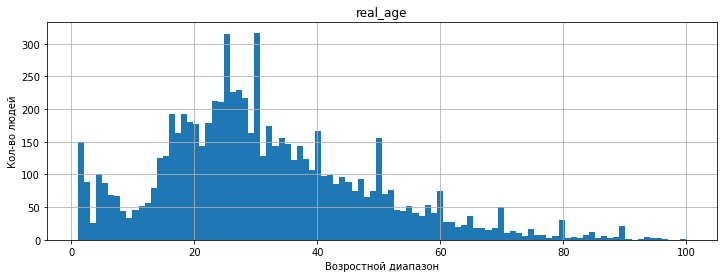

In [6]:
# Построим на гистограмму
labels.hist(figsize=(12, 4), bins=100)
plt.xlabel('Возростной диапазон')
plt.ylabel('Кол-во людей')
plt.show()

В нашем датасете 7591 фотография. И возрастной диапазон от 1 года до 100 лет. Каждая фотография соответсвует своему возрасту. Пропуски и явные дубликаты отсутсвуют. Названия столбцов соответсвуют PEP8. Типы данных: для фотографий - object, для возраста - целочисленный.

Относительно распределения можно сказать следующее:
- больше всего данных представленно для возрастного диапазона от 16 до 41;
- так же можно выделить возростной диапазон для новорожденных и возростной аудитории от 41 до 52;
- имеется просадка для детей от 8 до 12 лет и старшего поколения (более 60 лет);
- можно отметить мини-пики для возраста кратного десяти, после 40 лет.

В целом выборка для определения возраста у нас небольшая.

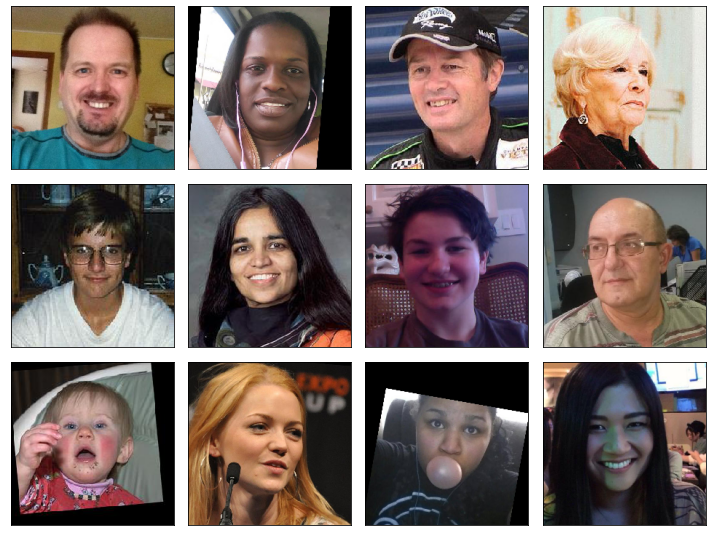

In [7]:
# Посмотрим первые 12 фотографий

features, target = next(labels_image_flow)

fig = plt.figure(figsize=(10,10))
for i in range(12):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

Загрузили и проанализировали наш датафрейм, состоящий из 7591 фотографий и целевого признака: возраста людей. Больше всего данных у нас есть для младенцев и людей от 12 до 53 лет. Для загрузки фотографий использовали метод ImageDataGenerator.


После визуального анализа фотографий можно предположить, что:
Учитывая инородные предметы на фотографиях, повороты лиц, повороты фотографий, задний фон, головные уборы, различные выражения лиц - то у модели могут возникнут затруднения с обучением.

## Обучение модели

``` python 
from tensorflow.keras.applications.resnet import ResNet50

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.layers import GlobalAveragePooling2D, Dense

from tensorflow.keras.models import Sequential

from tensorflow.keras.optimizers import Adam

import numpy as np

import pandas as pd

import tensorflow as tf


def load_train(path):

    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, horizontal_flip=True, rescale=1./255)
    train_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_gen_flow

def load_test(path):

    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    test_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_gen_flow


def create_model(input_shape):

    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet', 
                    include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mae'])


    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, 
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model
```

Found 5694 validated image filenames.

Found 1897 validated image filenames.

Train for 356 steps, validate for 119 steps

Epoch 1/10

356/356 - 66s - loss: 215.7153 - mae: 10.6548 - val_loss: 668.5795 - val_mae: 20.8768

Epoch 2/10

356/356 - 39s - loss: 83.6069 - mae: 6.9704 - val_loss: 129.0853 - val_mae: 8.5611

Epoch 3/10

356/356 - 39s - loss: 57.5698 - mae: 5.8234 - val_loss: 78.1219 - val_mae: 6.6375

Epoch 4/10

356/356 - 39s - loss: 43.3696 - mae: 5.0310 - val_loss: 90.4306 - val_mae: 7.3806

Epoch 5/10

356/356 - 39s - loss: 32.1632 - mae: 4.3152 - val_loss: 83.2079 - val_mae: 6.7434

Epoch 6/10

356/356 - 39s - loss: 24.6467 - mae: 3.8465 - val_loss: 76.8752 - val_mae: 6.6900

Epoch 7/10

356/356 - 39s - loss: 18.6953 - mae: 3.3136 - val_loss: 72.6034 - val_mae: 6.3027

Epoch 8/10

356/356 - 39s - loss: 16.1151 - mae: 3.0940 - val_loss: 68.0539 - val_mae: 6.1666

Epoch 9/10

356/356 - 39s - loss: 14.6158 - mae: 2.8973 - val_loss: 72.6015 - val_mae: 6.2925

Epoch 10/10

356/356 - 39s - loss: 14.6787 - mae: 2.9052 - val_loss: 66.8944 - val_mae: 6.2315

119/119 - 10s - loss: 66.8944 - mae: 6.2315

Test MAE: 6.2315

## Анализ обученной модели

**Вывод:**

Для сетевого супермаркета «Хлеб-Соль», который внедряет систему компьютерного зрения для обработки фотографий покупателей и определения их возраста, мы построили модель предсказания, которая будет:
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

Модель, построенная на архитектуре ResNet и предобученная на сети изображений ImageNet, позволяет на высоком уровне предсказывать возраст покупателей. Качество модели мы можем определить по метрике МАЕ, которая на тестовой выборке равна 6.23 - что является весьма неплохим показателем.

Все эти данные приводят нас к вывоводу, что использование GPU и нейронных сетей позволяет быстро и эффективно обработать большое количество информации с высокой точностью.
